In [3]:
import pandas as pd

In [4]:
df_raw = pd.read_excel('006__Impulse dataset.xlsx', None)

# try:
#     df.drop(df.index, inplace=True)
# except NameError:
#     pass

In [5]:
# список листов книги эксель
sheets = list(df_raw.keys())
for k, v in enumerate(sheets):
    print(k, v)

0 Основная комната – Зрители
1 QA – Зрители
2 DA – Зрители
3 Маркетинг – зрители
4 Дизайн – зрители
5 Python – зрители
6 Java – Зрители
7 Веб – зрители


In [6]:
# список нужных колонок листа
columns = ['Дата',
           'Имя участника',
           'На вебинаре с',
           'Досмотрел до',
           'Интервалы',
           'присутствия',
           'Продолжительность',
           'Устройство',
           'Клик по кнопке',
           'Город',
           'Регион',
           'Ссылка входа',
           'Переход с']

mapping = {'Дата': 'date',
           'Имя участника': 'name',
           'На вебинаре с': 'webinar_from',
           'Досмотрел до': 'webinar_to',
           'Интервалы': 'interval_from',
           'присутствия': 'interval_to',
           'Продолжительность': 'duration',
           'Устройство': 'device',
           'Клик по кнопке': 'click_to',
           'Город': 'city',
           'Регион': 'region',
           'Ссылка входа': 'entrance_link',
           'Переход с': 'source_link'}

In [7]:
def dataframe_processing(_df_raw_,
                         _sheet_index_,
                         _columns_):
    cdf = pd.DataFrame(_df_raw_[sheets[_sheet_index_]][_columns_])

    cdf = cdf.rename(columns=mapping)

    import hashlib
    import numpy as np

    cdf['hash'] = np.nan

    for index_, row_ in cdf.iterrows():
        if not pd.isnull(row_['name']):
            row_string = ''.join(str(value_) for value_ in row_.values)
            cdf.at[index_, 'hash'] = hashlib.sha256(row_string.encode('utf-8')).hexdigest()[:32]

    cdf.loc[cdf['name'].notnull(), cdf.columns != 'name'] = \
        cdf.loc[cdf['name'].notnull(), cdf.columns != 'name'].fillna("__EMPTY__")

    cdf = cdf.ffill(axis=0)

    cdf['click_to'] = cdf['click_to'].str.split(', ')
    cdf = cdf.explode('click_to')

    cdf = cdf[cdf['webinar_to'] != "__EMPTY__"].dropna()

    cdf[['Button_Name', 'Button_Time']] = cdf['click_to'].str.split(' в ', expand=True)

    cdf = cdf.replace({'__EMPTY__': '', None: ''})

    cdf['date'] = pd.to_datetime(cdf['date'])

    try:
        cdf['webinar_from'] = pd.to_datetime(cdf['webinar_from'], format='%H:%M').dt.time
        cdf['webinar_to'] = pd.to_datetime(cdf['webinar_to'], format='%H:%M').dt.time
    except ValueError:
        cdf['webinar_from'] = pd.to_datetime(cdf['webinar_from'], format='%H:%M:%S').dt.time
        cdf['webinar_to'] = pd.to_datetime(cdf['webinar_to'], format='%H:%M:%S').dt.time

    cdf['interval_from'] = pd.to_datetime(cdf['interval_from'], format='%H:%M:%S').dt.time
    cdf['interval_to'] = pd.to_datetime(cdf['interval_to'], format='%H:%M:%S').dt.time

    from datetime import datetime

    cdf['Button_Time'] = cdf['Button_Time'].apply(
        lambda x: datetime.strptime(str(x), '%H:%M').time() if x != '' else '')

    return cdf

In [8]:
current = dataframe_processing(df_raw, 1, columns)
current

,date,name,webinar_from,webinar_to,interval_from,interval_to,duration,device,click_to,city,region,entrance_link,source_link,hash,Button_Name,Button_Time
0,2023-01-14 12:22:00,Владислав,12:35:00,13:53:00,12:35:22,13:53:12,77.833333,ПК,«Python-разработчик» в 13:21,,,https://start.bizon365.ru/room/81268/impulse_q...,https://start.bizon365.ru/room/81268/impulse_g...,1e0c9d84d4caacaabb8d981db3b13a1a,«Python-разработчик»,13:21:00
0,2023-01-14 12:22:00,Владислав,12:35:00,13:53:00,12:35:22,13:53:12,77.833333,ПК,«Главная комната» в 13:53,,,https://start.bizon365.ru/room/81268/impulse_q...,https://start.bizon365.ru/room/81268/impulse_g...,1e0c9d84d4caacaabb8d981db3b13a1a,«Главная комната»,13:53:00
1,2023-01-14 12:22:00,Людмила+,12:35:00,13:23:00,12:35:27,13:23:12,47.750000,моб,,Томск,Томская область,https://start.bizon365.ru/room/81268/impulse_q...,https://start.bizon365.ru/room/81268/impulse_g...,1e780cd27295a4171e2f071f04b34242,,
2,2023-01-14 12:22:00,Юлия,12:35:00,12:47:00,12:35:27,12:47:27,12.000000,моб,,Санкт-Петербург,Санкт-Петербург,https://start.bizon365.ru/room/81268/impulse_q...,https://start.bizon365.ru/room/81268/impulse_g...,f60eec01cff853d72d307f0f1f9bba33,,
3,2023-01-14 12:22:00,Андрей+Пругло,12:35:00,13:33:00,12:35:32,12:39:02,3.500000,моб,,Краснодар,Краснодарский край,https://start.bizon365.ru/room/81268/impulse_q...,https://start.bizon365.ru/room/81268/impulse_g...,2334b28bf4c7579426f03a006efbc607,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023-01-14 12:22:00,Михаил,13:48:00,13:56:00,13:48:12,13:56:52,8.666667,ПК,,Минск,Минск,https://start.bizon365.ru/room/81268/impulse_q...,,2ae825b03570d79eb641bfe0499b5402,,
996,2023-01-14 12:22:00,Ольга+,13:49:00,13:49:00,13:49:12,13:49:47,0.583333,моб,«Графический дизайнер» в 13:49,Новосибирск,Новосибирская область,https://start.bizon365.ru/room/81268/impulse_q...,https://start.bizon365.ru/room/81268/impulse_g...,97f268f3633b0ba951cc34a6e6512607,«Графический дизайнер»,13:49:00
997,2023-01-14 12:22:00,Ольга,13:49:00,13:50:00,13:49:17,13:50:47,1.500000,ПК,«Главная комната» в 13:50,,,https://start.bizon365.ru/room/81268/impulse_q...,https://start.bizon365.ru/room/81268/impulse_d...,d505c15a1ea8c08c99d84779f6f79c60,«Главная комната»,13:50:00
998,2023-01-14 12:22:00,Ольга Журавлева,13:50:00,13:52:00,13:50:22,13:52:17,1.916667,моб,,Москва,Москва,https://start.bizon365.ru/room/81268/impulse_q...,https://start.bizon365.ru/room/81268/impulse_d...,72e9f8a73761d272393db2c5c6ea14bf,,


In [9]:
from datetime import timedelta, datetime


def time_plus(_time_, _timedelta_):
    start = datetime(2000, 1, 1,
                     hour=_time_.hour,
                     minute=_time_.minute,
                     second=_time_.second)
    end = start + _timedelta_
    return end.time()


min_webinar = time_plus(current.webinar_from.min(), timedelta(minutes=-1))
max_webinar = time_plus(current.webinar_to.max(), timedelta(minutes=3))
webinar_range = pd.date_range(str(min_webinar), str(max_webinar), freq="1min").time

In [10]:
result = pd.DataFrame(columns=['INCOME',
                               'OUTCOME',
                               'main',
                               'qa',
                               'da',
                               'marketing',
                               'design',
                               'python',
                               'java',
                               'web'],
                      index=webinar_range).reset_index()
result = result.rename(columns={'index': 'time'})

In [11]:
lag = 3

names = {'main': '«Главная комната»',
         'qa': '«Инженер по тестированию»',
         'da': '«Аналитик данных»',
         'marketing': '«Маркетолог»',
         'design': '«Графический дизайнер»',
         'python': '«Python-разработчик»',
         'java': '«Java-разработчик»',
         'web': '«Веб-разработчик»'}

for index_, row_ in result.iterrows():
    try:
        result.at[index_, 'INCOME'] = current.loc[(current['interval_from'] >= webinar_range[index_]) &
                                               (current['interval_from'] <= webinar_range[index_ + 1]) &
                                               (current['duration'] >= lag)].reset_index()['hash'].nunique()

        result.at[index_, 'OUTCOME'] = current.loc[(current['interval_to'] >= webinar_range[index_]) &
                                                (current['interval_to'] <= webinar_range[index_ + 1]) &
                                                (current['duration'] >= lag)].reset_index()['hash'].nunique()
    except IndexError:
        result.at[index_, 'INCOME'] = 0
        result.at[index_, 'OUTCOME'] = 0

    for key_, value_ in names.items():
        try:
            result.at[index_, key_] = current.loc[(current['Button_Time'] == webinar_range[index_]) &
                                                (current['interval_from'] <= webinar_range[index_]) &
                                                (webinar_range[index_] <= current['interval_to']) &
                                                # (current['duration'] >= lag) &
                                                (current['Button_Name'] == value_)].reset_index()['hash'].nunique()
        except IndexError:
            result.at[index_, key_] = 0

result

,time,INCOME,OUTCOME,main,qa,da,marketing,design,python,java,web
0,12:34:00,0,0,0,0,0,0,0,0,0,0
1,12:35:00,31,0,0,0,0,0,0,0,0,0
2,12:36:00,33,0,0,0,2,0,0,0,0,0
3,12:37:00,61,0,0,0,1,0,0,0,0,0
4,12:38:00,49,1,0,0,3,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
81,13:55:00,0,13,8,0,0,0,0,0,0,0
82,13:56:00,0,55,5,0,0,0,0,0,0,0
83,13:57:00,0,0,0,0,0,0,0,0,0,0
84,13:58:00,0,0,0,0,0,0,0,0,0,0


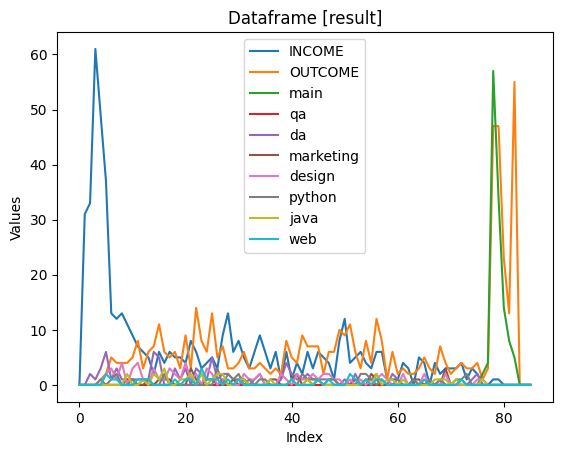

In [13]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
result.plot(ax=ax)

# Set the title and labels
ax.set_title('Dataframe [result]')
ax.set_xlabel('Index')
ax.set_ylabel('Values')

# Show the plot
plt.show()

In [ ]:
current.to_excel('current.xlsx')
result.to_excel('result.xlsx')